## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests, zipfile, io
from joblib import Parallel, delayed
import warnings

In [52]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [3]:
movies.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [4]:
filtered_movies = movies[movies['title'].str.contains("godfather", case=False)]
filtered_movies

movieId                                    title  \
659       858                    Godfather, The (1972)   
922      1221           Godfather: Part II, The (1974)   
1498     2023          Godfather: Part III, The (1990)   
5248     8607                  Tokyo Godfathers (2003)   
9541   172591  The Godfather Trilogy: 1972-1990 (1992)   

                            genres  
659                    Crime|Drama  
922                    Crime|Drama  
1498  Crime|Drama|Mystery|Thriller  
5248     Adventure|Animation|Drama  
9541            (no genres listed)

## Exploratory data analysis

In [5]:
df = movies.merge(ratings , on='movieId')
df.columns


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [6]:
movies_count = df['movieId'].nunique()
users_count = df['userId'].nunique()
print("Number of movies:", movies_count)
print("Number of users:", users_count)
num_rows = df.shape[0]
print("Number of ratings:", num_rows)
print("average ratings per user:",num_rows /users_count)

Number of movies: 9724
Number of users: 610
Number of ratings: 100836
average ratings per user: 165.30491803278687


all users have at least 20 ratings


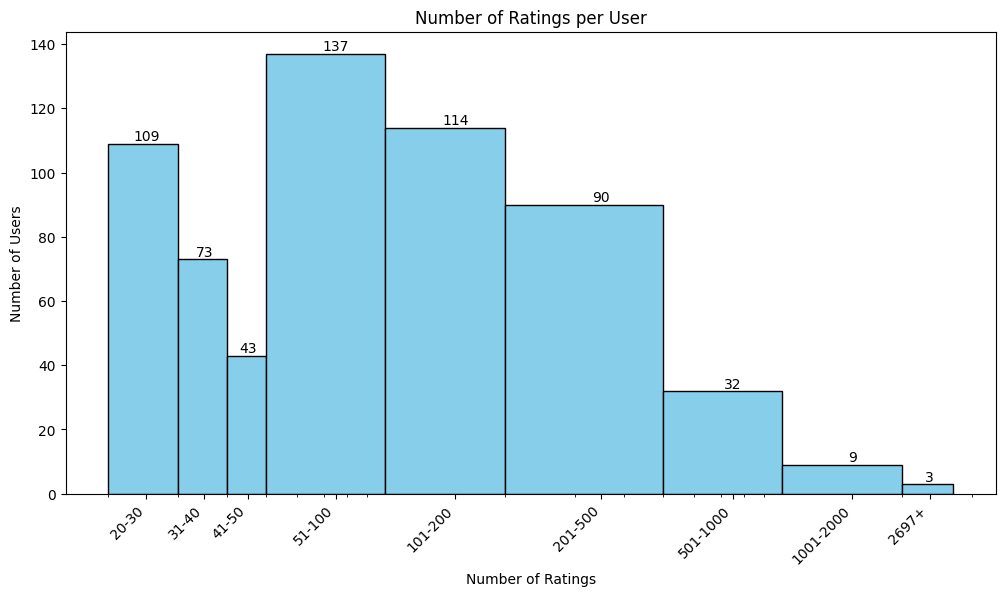

In [7]:
ratings_per_user = df.groupby('userId')['movieId'].count()
min_ratings = ratings_per_user.min()
print("all users have at least", min_ratings ,"ratings")
# Define bins for ranges
bins = [20, 30, 40, 50, 100, 200, 500, 1000, 2000, ratings_per_user.max()]  # Start from 20

# Plot the histogram of ratings per user
plt.figure(figsize=(12, 6))
hist, bins, _ = plt.hist(ratings_per_user, bins=bins, color='skyblue', edgecolor='black')
plt.xscale('log')  # Log scale for better visualization

# Labeling the x-axis ticks with actual values
tick_labels = ['20-30', '31-40', '41-50', '51-100', '101-200', '201-500', '501-1000', '1001-2000', f'{ratings_per_user.max() - 1}+']
tick_positions = [np.mean([bins[i], bins[i+1]]) for i in range(len(bins)-1)]
plt.xticks(tick_positions, tick_labels, rotation=45, ha='right')

plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

# Add text annotations on top of each bar
for i, count in enumerate(hist):
    plt.text(bins[i] + (bins[i + 1] - bins[i]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.show()


In [114]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Plot a countplot to visualize the distribution of ratings
    plt.figure(figsize=(12, 6))
    sns.countplot(x='rating', data=df, palette='viridis')
    
    # Annotate each bar with its count value
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                           textcoords='offset points')


    plt.show()

In [69]:
ratings_per_movie = df.groupby('movieId')['userId'].count()
per_movie_ratings_count = ratings_per_movie.tolist()

# Specify the number of bins or ranges
num_bins = 20

# Specify custom ranges
custom_ranges = [0,1,2,3,4,5,6,7,8,9, 10,15, 20, 30, 40, 50, 100]

# Plotting histogram with custom ranges
plt.figure(figsize=(10, 6))
plt.hist(per_movie_ratings_count, bins=custom_ranges, color='blue', edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings per Movie')
plt.show()
ratings_per_movie

movieId
1         215
2         110
3          52
4           7
5          49
         ... 
193581      1
193583      1
193585      1
193587      1
193609      1
Name: userId, Length: 9724, dtype: int64

In [70]:
num_movies_above_threshold = sum(count > 20 for count in per_movie_ratings_count)
movies_under_threshold = ratings_per_movie[ratings_per_movie < 20].index.tolist()
len(movies_under_threshold)

8427

In [75]:
movies = movies[~movies["movieId"].isin(movies_under_threshold)]
df = df[~df["movieId"].isin(movies_under_threshold)]

In [76]:
len(df)

67898

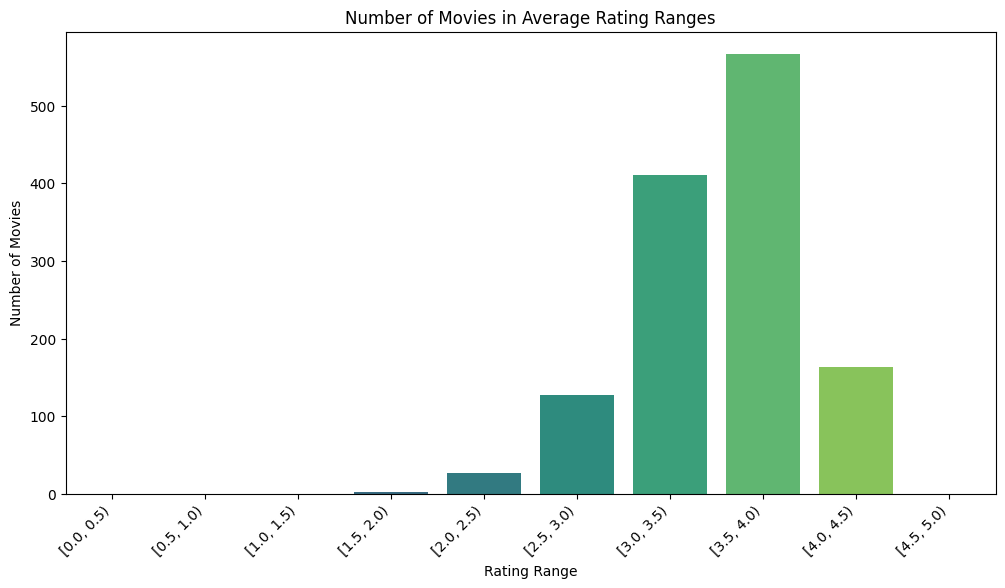

In [77]:

# Calculate average rating per movie
average_rating_per_movie = df.groupby('movieId')['rating'].mean()

# Create bins for rating ranges
bins = [i * 0.5 for i in range(11)]
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    # Bin the average ratings into ranges and count the number of movies in each range
    rating_ranges = pd.cut(average_rating_per_movie, bins, right=False)
    count_per_range = rating_ranges.value_counts().sort_index()
    
    # Plot the count of movies in each rating range
    plt.figure(figsize=(12, 6))
    sns.barplot(x=count_per_range.index.astype(str), y=count_per_range.values, palette='viridis')
    
    # Add labels and title
    plt.title('Number of Movies in Average Rating Ranges')
    plt.xlabel('Rating Range')
    plt.ylabel('Number of Movies')
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    # plt.show()


In [78]:
df.describe()

movieId        userId        rating
count   67898.000000  67898.000000  67898.000000
mean    12869.939512    316.273189      3.623060
std     26771.478528    181.360247      1.005625
min         1.000000      1.000000      0.500000
25%       849.000000    164.000000      3.000000
50%      2193.000000    313.000000      4.000000
75%      5418.000000    474.000000      4.000000
max    168252.000000    610.000000      5.000000

## data preprocessing

In [79]:
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)
import pandas as pd

# Assuming 'movies' is your DataFrame and 'title' is the column with movie titles
# Replace 'title' with the actual column name if it's different in your DataFrame

def fix_movie_title(title):
    # Remove leading "The" or "A"
    if title.endswith(", The"):
        title = "The " + title[:-5]
    elif title.endswith(", A"):
        title = "A " + title[:-3]
    return title

# Apply the function to the 'title' column
movies['title'] = movies['title'].apply(fix_movie_title)




movies[200:240]

movieId                                              title  \
576      707                                   Mulholland Falls   
577      708                        The Truth About Cats & Dogs   
584      719                                       Multiplicity   
585      720    Wallace & Gromit: The Best of Aardman Animation   
587      724                                          The Craft   
592      733                                           The Rock   
594      736                                            Twister   
595      737                                          Barb Wire   
596      741                Ghost in the Shell (Kôkaku kidôtai)   
598      743                                           Spy Hard   
599      745                    Wallace & Gromit: A Close Shave   
601      748                                        The Arrival   
602      750  Dr. Strangelove or: How I Learned to Stop Worr...   
607      762                                         Striptease   
613      778                                      Trainspotting   
615      780                      Independence Day (a.k.a. ID4)   
618      783                        The Hunchback of Notre Dame   
619      784                                      The Cable Guy   
620      785                                            Kingpin   
621      786                                             Eraser   
622      788                                The Nutty Professor   
627      799                                    The Frighteners   
630      802                                         Phenomenon   
633      805                                     A Time to Kill   
644      830                               The First Wives Club   
645      832                                             Ransom   
649      837                                            Matilda   
650      838                                               Emma   
656      849                                   Escape from L.A.   
658      852                                            Tin Cup   
659      858                                      The Godfather   
661      866                                              Bound   
668      880                           The Island of Dr. Moreau   
680      898                             The Philadelphia Story   
681      899                                Singin' in the Rain   
684      902                             Breakfast at Tiffany's   
685      903                                            Vertigo   
686      904                                        Rear Window   
690      908                                 North by Northwest   
691      909                                      The Apartment   

                                        genres  
576                       Crime|Drama|Thriller  
577                             Comedy|Romance  
584                                     Comedy  
585                 Adventure|Animation|Comedy  
587              Drama|Fantasy|Horror|Thriller  
592                  Action|Adventure|Thriller  
594          Action|Adventure|Romance|Thriller  
595                              Action|Sci-Fi  
596                           Animation|Sci-Fi  
598                                     Comedy  
599                  Animation|Children|Comedy  
601                     Action|Sci-Fi|Thriller  
602                                 Comedy|War  
607                               Comedy|Crime  
613                         Comedy|Crime|Drama  
615           Action|Adventure|Sci-Fi|Thriller  
618   Animation|Children|Drama|Musical|Romance  
619                            Comedy|Thriller  
620                                     Comedy  
621                      Action|Drama|Thriller  
622              Comedy|Fantasy|Romance|Sci-Fi  
627                     Comedy|Horror|Thriller  
630                              Drama|Romance  
633                             Drama|Thriller  
644                             

In [82]:
df.drop(['genres' , 'timestamp'] , axis=1 , inplace=True)

In [81]:
df.head()

movieId             title  userId  rating
0        1  Toy Story (1995)       1     4.0
1        1  Toy Story (1995)       5     4.0
2        1  Toy Story (1995)       7     4.5
3        1  Toy Story (1995)      15     2.5
4        1  Toy Story (1995)      17     4.5

In [83]:
# Filter the DataFrame to include only liked movies (rating 3 stars or more)
liked_movies_df = df[df['rating'] >= 3.5]

# Group by 'userId' and aggregate the liked movies into a list
user_liked_movies = liked_movies_df.groupby('userId')['movieId'].agg(list).reset_index()
# user_liked_movies_ids = liked_movies_df.groupby('userId')['movieId'].agg(list).reset_index()

# Rename the column to 'liked_movies'
user_liked_movies.rename(columns={'movieId': 'liked_movies'}, inplace=True)

user_liked_movies


userId                                       liked_movies
0         1  [1, 3, 6, 47, 50, 101, 110, 151, 163, 216, 231...
1         2  [333, 1704, 3578, 6874, 8798, 46970, 48516, 58...
2         3                      [849, 1275, 1587, 2288, 3703]
3         4  [215, 260, 265, 319, 342, 345, 348, 368, 457, ...
4         5  [1, 21, 34, 36, 50, 58, 110, 247, 261, 296, 36...
..      ...                                                ...
604     606  [17, 18, 29, 32, 36, 50, 58, 70, 105, 110, 111...
605     607  [1, 36, 110, 150, 165, 292, 318, 377, 380, 434...
606     608  [10, 16, 21, 32, 34, 47, 50, 110, 145, 170, 17...
607     609                 [10, 253, 296, 318, 356, 457, 590]
608     610  [1, 6, 16, 32, 47, 50, 70, 95, 110, 111, 112, ...

[609 rows x 2 columns]

## Training

In [84]:
transactions = user_liked_movies['liked_movies'].tolist()
test_set = transactions[500:600]


In [85]:
transactions

609

In [86]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
pd.set_option('display.max_columns', None)

In [87]:
s = user_liked_movies['liked_movies'][0:500].explode()
user_liked_movies_binary = user_liked_movies[['userId']][0:500].join(pd.crosstab(s.index, s))

# Display the resulting DataFrame
print(f"Binary matrix shape: {user_liked_movies_binary.shape}")
user_liked_movies_binary.head()
user_liked_movies_binary = user_liked_movies_binary.drop('userId', axis = 1)


Binary matrix shape: (500, 1298)


In [88]:
def association_all(data_rating):
    frequent = apriori(data_rating, min_support = 0.07, use_colnames = True)
    frequent['length'] = frequent['itemsets'].apply(lambda x: len(x))
    frequent[(frequent['length'] == 2) & \
             (frequent['support'] >= 0.07)]
    data_rating = association_rules(frequent, metric = "lift", min_threshold = 2)
    data_rating = data_rating[(data_rating['lift'] >=2) & (data_rating['confidence'] >= 0.07)]
    return data_rating

In [89]:
associations = association_all(user_liked_movies_binary)

/home/mohamed/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [90]:
# Convert frozensets to lists for 'antecedents' column
associations['antecedents'] = associations['antecedents'].apply(list)

# Convert frozensets to lists for 'consequents' column
associations['consequents'] = associations['consequents'].apply(list)


# Here recommender function

In [91]:
def recommendations_2(film):
    filtered_rows = associations[associations['antecedents'].apply(lambda x:  film in x)]
    # print(len(filtered_rows))
    recs_2 = filtered_rows.nlargest(columns="lift", n=150)["consequents"].tolist()
    lists = []
    for r in recs_2:
        for i in r:
            lists.append(i)
    # print(lists)
    final = list(set(lists))
    final_list_2 =[]
    for item in final:
        final_list_2.append(id_to_name_mapping.get(item))
    return final ##final_list_2 is list of movie titles
import pandas as pd

def multi_rec2(films, associations):
    result_rows = []
    sublists = get_sublists(films)[1:]

    for sublist in sublists:
        # Sort the sublist for comparison
        sorted_sublist = sorted(sublist)

        # Filter rows where 'antecedents' is equal to the sorted sublist
        matching_rows = associations[associations['antecedents'].apply(lambda x: sorted(x) == sorted_sublist)]

        # Append the matching rows to the result list
        result_rows.extend(matching_rows.values.tolist())

    # Create a DataFrame from the list of rows
    result_df = pd.DataFrame(result_rows, columns=associations.columns)

    if len(result_df) > 0:
        # Sort by 'consequents' length and then by 'lift'
        result_df['consequents_length'] = result_df['consequents'].apply(len)
        result_df = result_df.sort_values(by=['consequents_length', 'support'], ascending=[False, False])

        # Extract the top 30 'consequents' values
        result_df = list(result_df.head(50)["consequents"])
        # print(result_df)
        # Flatten the list of lists
        
        result_df = [i for sublist in result_df for i in sublist]

    return result_df



def get_sublists(lst):
    sublists = []
    for i in range(1, len(lst) + 1):
        for j in range(i, len(lst) + 1):
            sublists.append(lst[i-1:j])
    return sublists




In [92]:
import pandas as pd

def create_movie_mappings(df):
    # Creating a mapping from movieid to moviename
    id_to_name = dict(zip(df['movieId'], df['title']))
    
    # Creating a mapping from moviename to movieid
    name_to_id = dict(zip(df['title'], df['movieId']))
    
    return id_to_name, name_to_id

# Example usage:

id_to_name_mapping, name_to_id_mapping = create_movie_mappings(movies)

# Get movie name for a given movie ID
movie_id = 2
movie_name = id_to_name_mapping.get(movie_id, 'Movie not found')
print(f"Movie ID {movie_id} corresponds to {movie_name}")

# Get movie ID for a given movie name
movie_name = 'Movie B'
movie_id = name_to_id_mapping.get(movie_name, 'Movie not found')
print(f"Movie name '{movie_name}' corresponds to Movie ID {movie_id}")


Movie ID 2 corresponds to Jumanji
Movie name 'Movie B' corresponds to Movie ID Movie not found


In [93]:
c = multi_rec2([1,name_to_id_mapping.get('Inception'),74458],associations)
c

[5952,
 4993,
 356,
 2571,
 7153,
 5952,
 4993,
 2571,
 2959,
 7153,
 5952,
 4993,
 2571,
 7153,
 58559,
 5952,
 4993,
 356,
 2959,
 7153,
 5952,
 4993,
 2571,
 7153,
 5952,
 4993,
 7153,
 58559,
 5952,
 4993,
 7153,
 2959,
 5952,
 4993,
 356,
 7153,
 2571,
 356,
 318,
 2959,
 5952,
 4993,
 7153,
 318,
 5952,
 4993,
 2571,
 356,
 4993,
 2571,
 356,
 7153,
 296,
 2571,
 356,
 318,
 296,
 2571,
 356,
 2959,
 296,
 2571,
 356,
 58559,
 58559,
 2571,
 356,
 2959,
 5952,
 7153,
 2571,
 356,
 5952,
 4993,
 7153,
 593,
 5952,
 4993,
 2571,
 2959,
 4993,
 2571,
 7153,
 2959,
 5952,
 4993,
 2571,
 58559,
 4993,
 2571,
 7153,
 58559,
 5952,
 4993,
 4226,
 7153,
 5952,
 4993,
 296,
 7153,
 2571,
 356,
 318,
 58559,
 5952,
 7153,
 2571,
 2959,
 5952,
 7153,
 2571,
 58559,
 296,
 356,
 318,
 2959,
 296,
 2571,
 318,
 2959,
 296,
 593,
 58559,
 2959,
 296,
 58559,
 2571,
 2959,
 58559,
 356,
 318,
 2959,
 58559,
 858,
 318,
 2959,
 58559,
 2571,
 318,
 2959,
 7153,
 2571,
 356,
 2959,
 296,
 356,
 3

In [94]:
i = 0
for movie in movies["movieId"].tolist():
    
    if len(recommendations_2(movie)) < 10:
        i+=1
        print(i)
        # movies = movies[movies["movieId"] != movie]
print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [98]:
len(associations)

500422

In [25]:
# resultsinDataFrame = pd.read_pickle('results.pkl')  # Load from the pickle file
# print(resultsinDataFrame) 

## Testing

In [96]:
def recommendations(film):
    result = resultsinDataFrame[(resultsinDataFrame['Item #1'] == film) ]\
        .nlargest(n=50, columns='Support')
    return result

def multi_recommendation(films, count):
    combined_results = pd.DataFrame()

    for film in films:
        # Filter the results DataFrame for the current film
        filtered_results = recommendations(film)
            
        # Append the filtered results to the combined_results DataFrame
        combined_results = pd.concat([combined_results, filtered_results])

    # Reset the index of the combined DataFrame
    combined_results = combined_results.reset_index(drop=True)

    # Filter out rows where 'Item #2' is in the list of input movies
    combined_results = combined_results[~combined_results["Item #2"].isin(films)]

    combined_results = combined_results.groupby('Item #2')['Lift'].sum().reset_index() 
    # Get the top 20 recommendations based on 'Support'
    c = combined_results
    # c = c.sort_values(by='Support', ascending=False)['Item #2'].tolist()
    combined_results = combined_results.nlargest(n=count, columns='Lift')

    return combined_results

## Evaluation 

In [112]:
def calculate_recall_precision_at_k(relevant_items, recommended_items,k):
    relevant_set = set(relevant_items)
    recommended_set = set(recommended_items)

    # Calculate recall
    precision_at_k = len(relevant_set.intersection(recommended_set)) / k


    # Calculate precision
    recall_at_k = len(relevant_set.intersection(recommended_set)) / (len(relevant_set)+1)

    return recall_at_k, precision_at_k

# Example usage:
# test_set = [...]  # Your test set of users and their relevant items
k = 5  # Replace with the desired value of k

print(k)
recall_sum =0
precision_sum =0 
print("   ","#"*100)
for u in test_set[0:20]:
    relevant_items = u  # Extract relevant items for user u
    recommendations_list = recommendations_2(u[0])[0:k]
    # Replace with your recommendation function
    # print(recommendations_list)
    # flattened_and_unique = list(set(item for sublist in recommendations_list for item in sublist))
    recall_at_k, precision_at_k = calculate_recall_precision_at_k(relevant_items, recommendations_list,min(len(recommendations_list)+1,k))
    print(len(recommendations_list) ," #",  int(precision_at_k *100) *"#" ,sep='')
    if len(recommendations_list) > 0: 
        
        recall_sum +=recall_at_k
        precision_sum +=precision_at_k 
    else :
        print("000")
    # print(f"User{len(u)} : Recall@{k} = {recall_at_k:.4f}, Precision@{k} = {precision_at_k:.4f}")
print(recall_sum/5 , precision_sum/5)

5
    ####################################################################################################
0 #
000
0 #
000
5 #####################
5 #####################
0 #
000
5 #########################################
5 #
5 #################################################################################
5 #
5 #####################
5 #########################################
5 #####################
5 #############################################################
5 #########################################
5 #
5 #####################
0 #
000
5 #
1 ###################################################
5 #####################
0.13928903998840497 0.8600000000000001


In [105]:
def recommendations(film):
    result_ids = recommendations_2(name_to_id_mapping.get(film))
    result_titles = []
    for id in result_ids :
        result_titles.append(id_to_name_mapping.get(id))
    return result_titles
        

In [116]:
recommendations("")

[]